In [6]:
import pandas as pd
import os
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from wordcloud import WordCloud

In [7]:
# Names of files to import and its shortname
dataset_names = {"word_counts_novels_clean.txt", 
            "word_counts_news_clean.txt",
            "word_counts_arxiv_abs_clean.txt"}

short_names = {"word_counts_novels_clean.txt" : "Novels", 
            "word_counts_news_clean.txt" : "News",
            "word_counts_arxiv_abs_clean.txt" : "ArXiv Abstracts"}

In [8]:
# Read all files and group by word, to avoid duplicated words
data = {}

for name in dataset_names:
    data_path = os.path.join(os.getcwd(), "data", name)

    data[name] = pd.read_csv(data_path, names=['count', 'word'])
    data[name] = data[name].groupby(by="word").sum().reset_index()

In [ ]:
# Explore vocabulary
for name, words in data.items():
    max_word = 500

    wordcloud = WordCloud(width=800, height=400,
                        background_color='white',
                        colormap='viridis',  
                        max_words=max_word).generate(" ".join(words.word))

    # Display the generated word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {max_word} words in {short_names[name]} cleaned")
    plt.show()

In [9]:
# Calculate n_types considering different n_words
# Strategy: sample with repetition and using "counts" as weight
# so that more common words are more commontly chosen

n_types = {}
n_words = {}

for name, df in data.items():
    n = len(df)
    sparce = 100

    types_dict = dict()

    for i in range(0, n, sparce):
        m = df.sample(n = i+1, weights="count",replace=True, random_state=456)
        types_dict[i+1] = len(set(m.word))  # remove duplicates using a set

    n_words[name] = np.array([key for key in types_dict.keys()])
    n_types[name] = np.array([key for key in types_dict.values()])


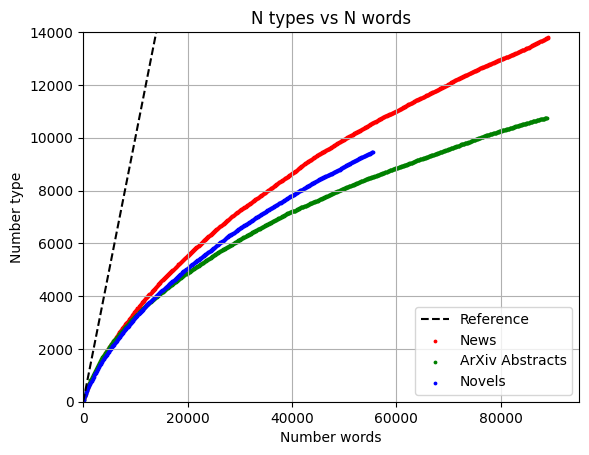

In [71]:
# Visualize n_words vs n_type respect to 
# its max relation (1:1) 
for name in dataset_names:
    new_name = short_names[name]

    if new_name == "News":
        col = "red"
        plt.plot(n_words[name], n_words[name], label = "Reference", color="black", linestyle='--')
    elif new_name == "Novels":
        col = "blue"
    else:
        col = "green"

    plt.scatter(n_words[name], n_types[name], label = new_name, s=3, color=col, marker='o')
    plt.xlim(0, 95000)
    plt.ylim(0, 14000)

    plt.legend()
    plt.grid()
    plt.title("N types vs N words")
    plt.xlabel("Number words")
    plt.ylabel("Number type")

In [10]:
# Define Heaps law
def Heaps_law(n_words, k, beta):
    return k * (n_words ** beta)

In [59]:
# Fit the function using initial guesses and bounds to help find global maximum
k = {}
beta = {}
sigma_ab = {}

for name in data.keys():
    params = curve_fit(Heaps_law, n_words[name], n_types[name], p0 = (50, 0.70), bounds = (0, [np.inf, 1]))
    fits, covar = params
    k[name], beta[name] = fits

    print("Processed dataset:", name)
    print("k=", k[name], "B=",beta[name])

    # approximate the error of the fit
    sigma_ab[name] = np.sqrt(np.diagonal(covar))

Processed dataset: word_counts_news_clean.txt
k= 12.296499549031163 B= 0.6173761855105376
Processed dataset: word_counts_arxiv_abs_clean.txt
k= 22.486004346272708 B= 0.5428742855280844
Processed dataset: word_counts_novels_clean.txt
k= 9.054553790563409 B= 0.6376407759238537


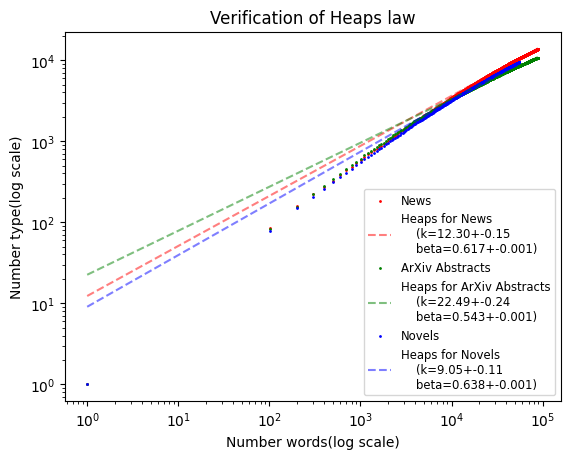

In [75]:
# Plot fitted functions and original data

for name in data.keys():
    # plot points
    new_name = short_names[name]

    if new_name == "News":
        col = "red"
    elif new_name == "Novels":
        col = "blue"
    else:
        col = "green"

    plt.scatter(n_words[name], n_types[name], label = new_name, s=1, color=col, marker='o')

    # Plot heaps
    lab = f"""Heaps for {short_names[name]}
    (k={k[name]:.2f}+-{sigma_ab[name][0]*2:.2f} 
    beta={beta[name]:.3f}+-{sigma_ab[name][1]*2:.3f})"""

    plt.plot(n_words[name], Heaps_law(n_words[name], k[name], beta[name]), color = col, label = lab, linestyle='--', alpha = 0.5)

    plt.yscale("log")
    plt.xscale("log") 
    plt.legend(fontsize='small', loc = 'lower right')
    plt.title("Verification of Heaps law")
    plt.xlabel("Number words(log scale)")
    plt.ylabel("Number type(log scale)")


In [83]:
# Calculate error of the fit
RMSE = {}

for name in data.keys():

    predicted = Heaps_law(n_words[name], *([k[name], beta[name]]))
    RMSE[name] = root_mean_squared_error(y_true=n_types[name], y_pred = predicted)

RMSE

In [34]:
# Try to improve results considering two Heaps functions
lims_range = [1000, 2000, 3000, 4000]
k2 = {}
beta2 = {}
sigma2_ab = {}
RMSE2 = {}

for name in data.keys():
    
    for lim in lims_range:
        # split data in two datasets
        masks = [np.where(n_words[name] <= lim)[0], np.where(n_words[name] > lim)[0]]

        k2_i = []
        beta2_i = []
        sigma2_i = []
        
        # Calculate parameters and its error
        for mask in masks:

            n_words_mask = n_words[name][mask]
            n_types_mask = n_types[name][mask]

            params = curve_fit(Heaps_law, n_words_mask, n_types_mask, bounds = (0, [np.inf, 1]))
            fits, covar = params
            k_i, beta_i = fits

            # save params
            k2_i.append(k_i)
            beta2_i.append(beta_i)

            # approximate the error of the fit
            sigma_i = np.sqrt(np.diagonal(covar))
            sigma2_i.append(sigma_i)

    # Calculate RMSE and store the best iteration
    for name in data.keys():
        masks = [np.where(n_words[name] <= lim)[0], np.where(n_words[name] > lim)[0]]
        
        for i in range(len(masks)):
            n_words_mask = n_words[name][masks[i]]

            if i == 0:
                predicted = Heaps_law(n_words_mask, *([k2_i[i], beta2_i[i]]))
            else:
                predicted = np.append(predicted, Heaps_law(n_words_mask, *([k2_i[i], beta2_i[i]])))

        RMSE2_i = root_mean_squared_error(y_true=n_types[name], y_pred = predicted)

        # If its the first iteration, store the result. 
        # For next one, store RMSE only if its lower than previous iteration
        if name not in RMSE2.keys():
            RMSE2[name] = RMSE2_i
            k2[name] = k2_i
            beta2[name] = beta2_i
            sigma2_ab[name] = sigma2_i
            

        elif RMSE2_i < RMSE2[name]:
            RMSE2[name] = RMSE2_i
            k2[name] = k2_i
            beta2[name] = beta2_i
            sigma2_ab[name] = sigma2_i

    print(f"Minimum RMSE for {name} is in {lim} words")

Minimum RMSE for word_counts_news_clean.txt is in 2000 words
Minimum RMSE for word_counts_news_clean.txt is in 2000 words
Minimum RMSE for word_counts_news_clean.txt is in 2000 words
